In [1]:
import os
for dirname, _, filenames in os.walk('/content/Google_Stock_Price_Train.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv("/content/Google_Stock_Price_Train.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
df['Volume'].apply(type)

0       <class 'str'>
1       <class 'str'>
2       <class 'str'>
3       <class 'str'>
4       <class 'str'>
            ...      
1253    <class 'str'>
1254    <class 'str'>
1255    <class 'str'>
1256    <class 'str'>
1257    <class 'str'>
Name: Volume, Length: 1258, dtype: object

In [8]:
obj_cols = ['Volume', 'Close']
df[obj_cols] = df[obj_cols].replace('[\,,]', '', regex=True).astype(float)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   float64
 5   Volume  1258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


In [10]:
df2 = df.copy()
df2.shape

(1258, 6)

In [11]:
df2['Date'].describe()

count         1258
unique        1258
top       1/3/2012
freq             1
Name: Date, dtype: object

In [12]:
df2.drop(['Date'],axis=1, inplace=True)
df2.shape

(1258, 5)

In [13]:
X, y = df2.iloc[:, :-1],df.iloc[:, [-1]]
print('shape of data_x {}\nshape of data_y {}'.format(X.shape,y.shape))

shape of data_x (1258, 4)
shape of data_y (1258, 1)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

print('X_train: {}\tX_test: {}\ny_train: {}\ty_test: {}'.format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

X_train: (1006, 4)	X_test: (252, 4)
y_train: (1006, 1)	y_test: (252, 1)


In [15]:
X_temp = X_train.values
y_temp = y_train.values

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import numpy as np
from matplotlib import pyplot

In [20]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
reframed = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))

In [22]:
values = reframed
n_train_hours = 30 * 12
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(360, 1, 3) (360, 1) (646, 1, 3) (646, 1)


In [23]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

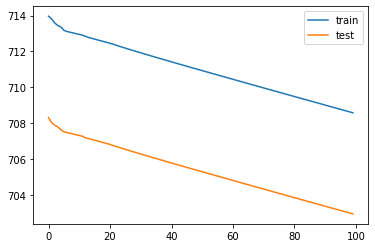

In [24]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()